In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
PYTHON_PATHS = ["../.."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        

from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict

# Test Dataset Images

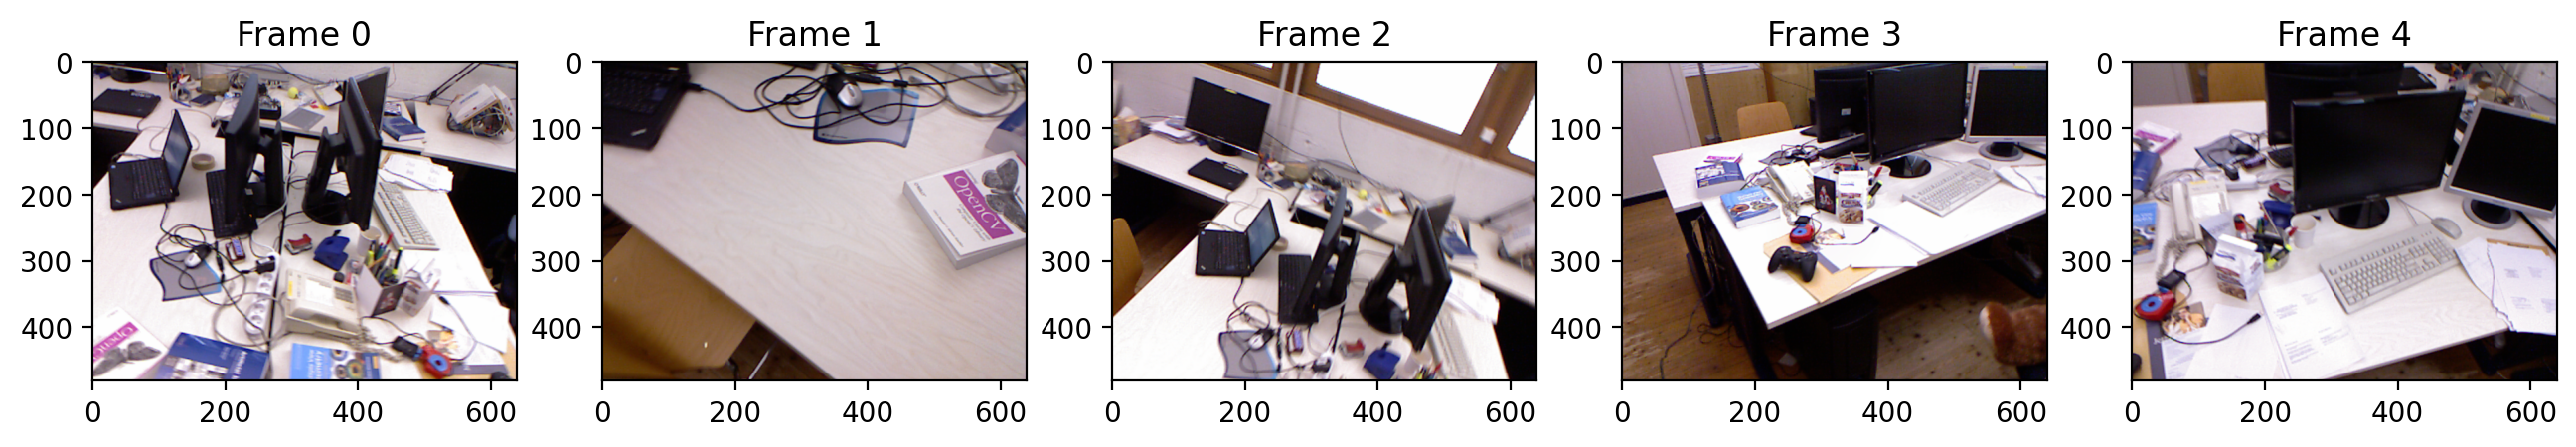

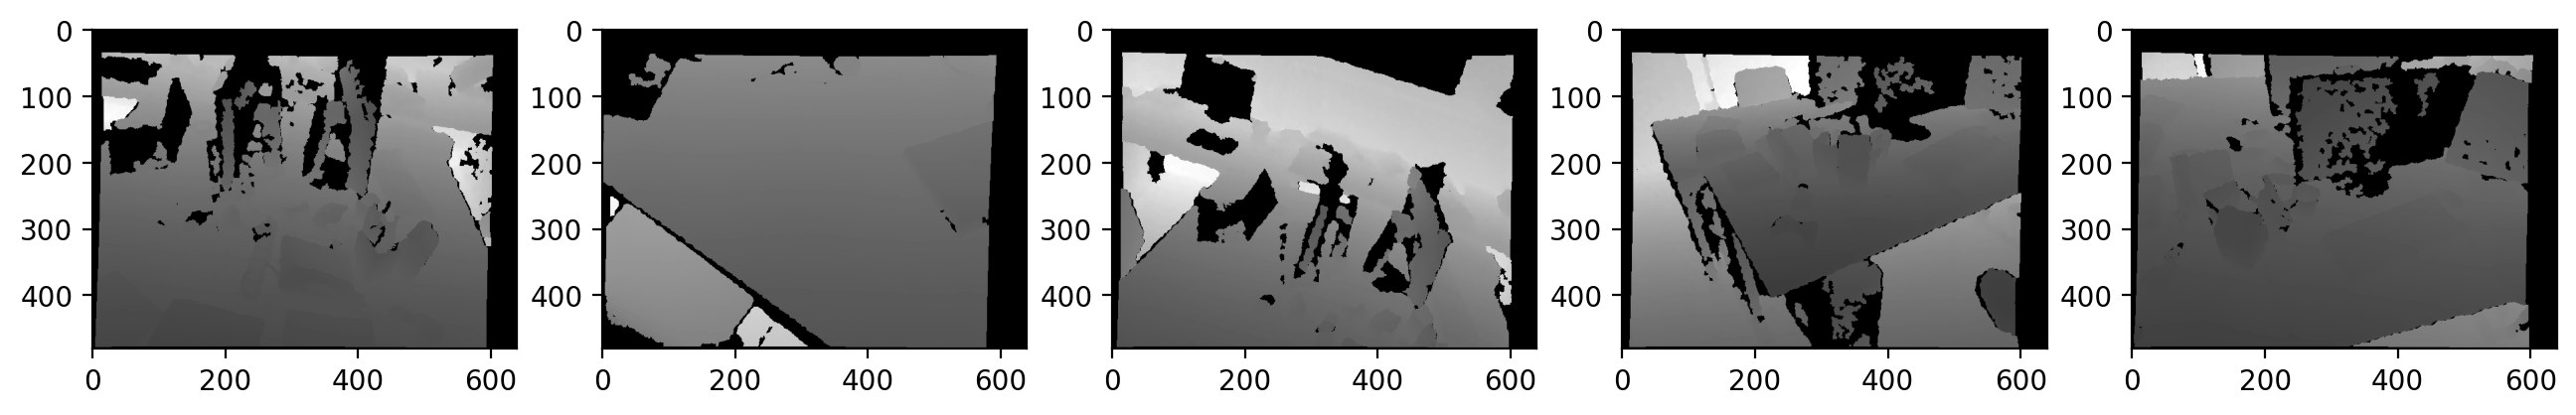

In [3]:
frames = [0, 2]
test_images_list = [
"1305031458.159638.png", "1305031462.692548.png", "1305031464.959763.png","1305031467.695886.png",  "1305031469.296754.png"
]
test_depthes_list = [
    "1305031458.144808.png", "1305031462.680788.png", "1305031464.952471.png", "1305031467.686044.png", "1305031469.288263.png"
]

figure = plt.figure(dpi=200, figsize=(16,10))

for i in range(len(test_images_list)):
    
    color_image_path = str(Path(f"../../tests/datasets/tum rgbd/rgbd_dataset_freiburg1_desk/rgb/{test_images_list[i]}"))
    color_image = cv2.imread(color_image_path)
    plt.subplot(1,5,i+1)
    plt.title(f'Frame {i}')
    plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))


    
figure = plt.figure(dpi=200, figsize=(16,10))
factor = 5000 # for the 16-bit PNG files
# OR: factor = 1 # for the 32-bit float images in the ROS bag files
for i in range(len(test_images_list)):
    
    depth_image_path = str(Path(f"../../tests/datasets/tum rgbd/rgbd_dataset_freiburg1_desk/depth/{test_depthes_list[i]}"))
    depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / factor
    depth_image = np.clip(depth_image, 0, 4)
    plt.subplot(1,5,1+i)
    plt.imshow(depth_image, cmap="gray")
    

# Test training on single image

# Test training on 5 images

## Create Dataset Loader

In [4]:
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.input.model_buffer_input import ModelBufferInput

In [5]:
dataset_params = {'dataset_path': "../../tests/datasets/tum rgbd/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [131, 257, 325, 407, 455],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading ../../tests/datasets/tum rgbd/rgbd_dataset_freiburg1_desk/data_association_file.txt


## Create Model

In [6]:
from imap.model.nerf import NERF
from imap.model.embeddings.gaussian_positional_encoding import GaussianPositionalEncoding

In [7]:
model_parameters = AttributeDict(
    name="NERF",
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    minimal_depth=0.01,
    positional_embedding = AttributeDict(
                                        name = 'GaussianPositionalEncoding',
                                        encoding_dimension=92,
                                        sigma=25,
                                        use_only_sin=True
                                        )
)

factory = UniversalFactory([NERF, GaussianPositionalEncoding])
model = factory.make_from_parameters(model_parameters, camera_info=camera)

## Train the Model

In [8]:
from imap.trainers.trainers import ModelTrainer
from imap.model.active_sampling.image_active_sampling import ImageActiveSampling

In [9]:
model.cuda()
model.train()
trainer = ModelTrainer(model.parameters(), lr=0.01)
num_epochs = 300
points_per_image = int(200)


image_active_sampler = ImageActiveSampling(640, 480)
model_buffer_input = ModelBufferInput(points_per_frame=points_per_image, 
                                      image_active_sampler=image_active_sampler)

for i in tqdm(range(num_epochs)):
    # update model input buffer
    for color_image, depth_image, position in dataset_loader:
        state = camera.create_state(color_image, depth_image, position)
        model_buffer_input.update_data(state)
        
    # train the model
    for batch in model_buffer_input:
        loss = trainer.train(model, batch)
    # trainer.reset_params()
    
    if i%5 == 0:
        print(f"loss {loss['loss']}")
    # clear_output(wait=True)
    
torch.cuda.empty_cache()

  0%|          | 0/300 [00:00<?, ?it/s]

loss 2.0170443058013916
loss 1.8866955041885376
loss 1.5252352952957153
loss 1.1726367473602295
loss 1.3156499862670898
loss 1.1412805318832397
loss 1.0683417320251465
loss 1.0268518924713135
loss 1.162596583366394
loss 1.4093374013900757
loss 0.9140408039093018
loss 0.9122805595397949
loss 0.8538519144058228
loss 1.0855674743652344
loss 0.8233393430709839
loss 0.9906638860702515
loss 1.4096707105636597
loss 0.9104778170585632
loss 0.9557247161865234
loss 0.7968117594718933
loss 0.966507613658905
loss 0.9206258654594421
loss 0.8834114074707031
loss 0.8507881164550781
loss 0.8405075073242188
loss 0.8579801917076111
loss 0.9348044991493225
loss 0.8220634460449219
loss 0.8166028261184692
loss 0.9431452751159668
loss 0.8988898396492004
loss 0.8066016435623169
loss 0.6948243379592896
loss 0.9600943326950073
loss 0.7889711856842041
loss 0.8522921800613403
loss 0.7259480357170105
loss 0.8517672419548035
loss 0.8176357746124268
loss 0.8093632459640503
loss 0.9127145409584045
loss 0.78419691324

## Show the results

In [10]:
from imap.utils.utils import *


In [11]:
# prepare image coordinates

scale = 1
height = color_image.shape[0]
width = color_image.shape[1]
x, y = generate_image_meshgrid(width, height, scale)
np_pixels = get_ji_pixels_from_meshgrid(x, y, scale)

In [12]:


# positions for rendering
positions = []
for _, _, position in dataset_loader:
    color_image = camera.process_color_image(color_image)
    depth_image = camera.process_depth_image(depth_image)[0]
    positions.append(camera.process_positions(position))



In [13]:
# reder the image

batch_size = 4096

model = model.cuda()
model.eval()


pixels = torch.from_numpy(np_pixels.copy()).cuda()

color_coarse_images = []
depth_coarse_images =[]
color_fine_images = []
depth_fine_images = []

mean = camera._color_mean
std = camera._color_std

with torch.no_grad():
    for pos in positions:
        position = torch.from_numpy(pos).to('cuda')
        output_coarse_color = []
        output_coarse_depth = []
        output_fine_color = []
        output_fine_depth = []

        for i in tqdm(range(int(np.ceil(pixels.shape[0] / batch_size)))):
            output = model(pixels[i * batch_size : i * batch_size + batch_size],
                                 position)
            output_coarse_color.append(output[0])
            output_coarse_depth.append(output[1])
            output_fine_color.append(output[2])
            output_fine_depth.append(output[3])

        reconstructed_image = reshape_points_list_to_image(output_coarse_color,height, width, scale).detach().cpu().numpy()
        reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
        reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
        color_coarse_images.append(reconstructed_image)
        
        reconstructed_image = reshape_points_list_to_image(output_fine_color,height, width, scale).detach().cpu().numpy()
        reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
        reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
        color_fine_images.append(reconstructed_image)
        
        reconstructed_depth = torch.cat(output_coarse_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
        depth_coarse_images.append(reconstructed_depth)
        
        
        reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
        depth_fine_images.append(reconstructed_depth)

del output_coarse_color, output_coarse_depth, output_fine_color, output_fine_depth, position, pixels
torch.cuda.empty_cache()

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

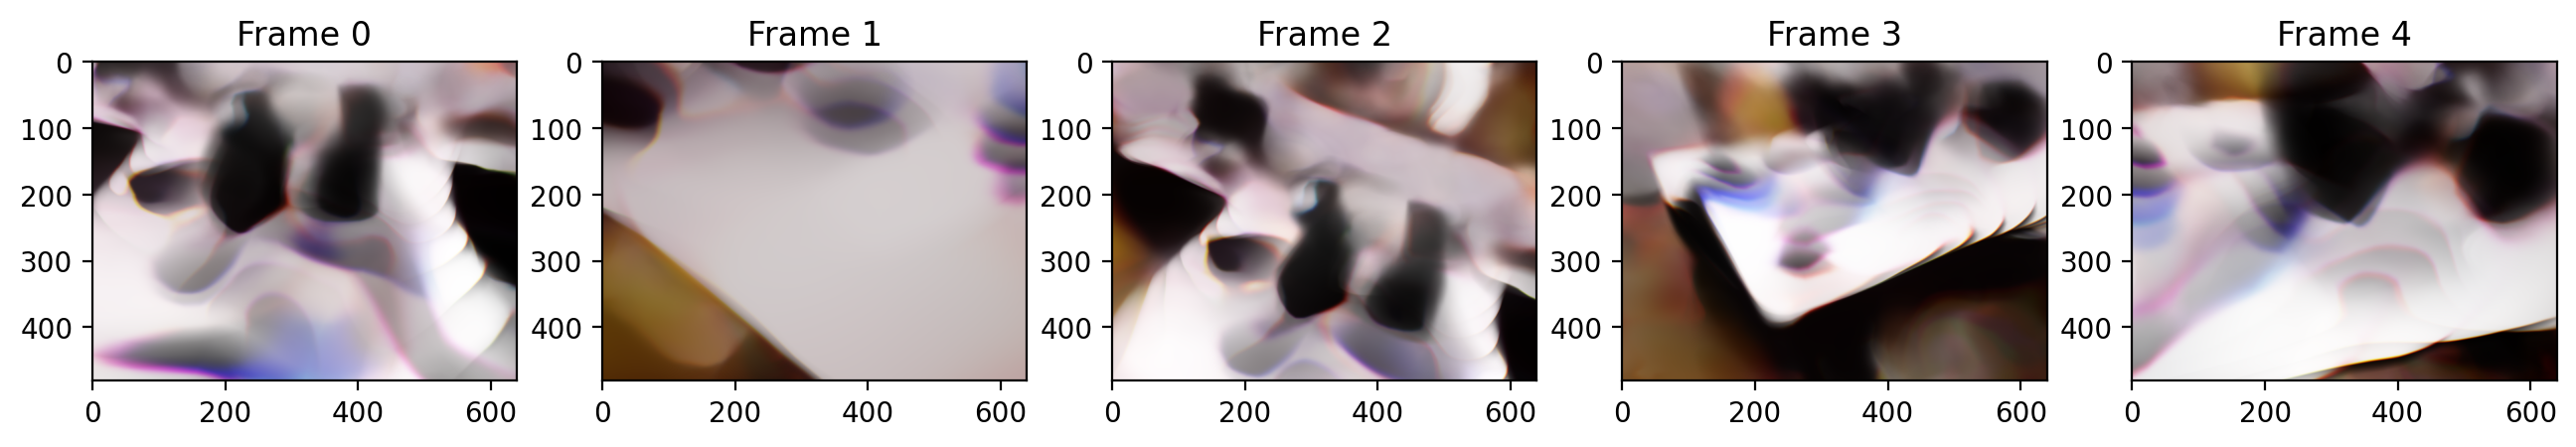

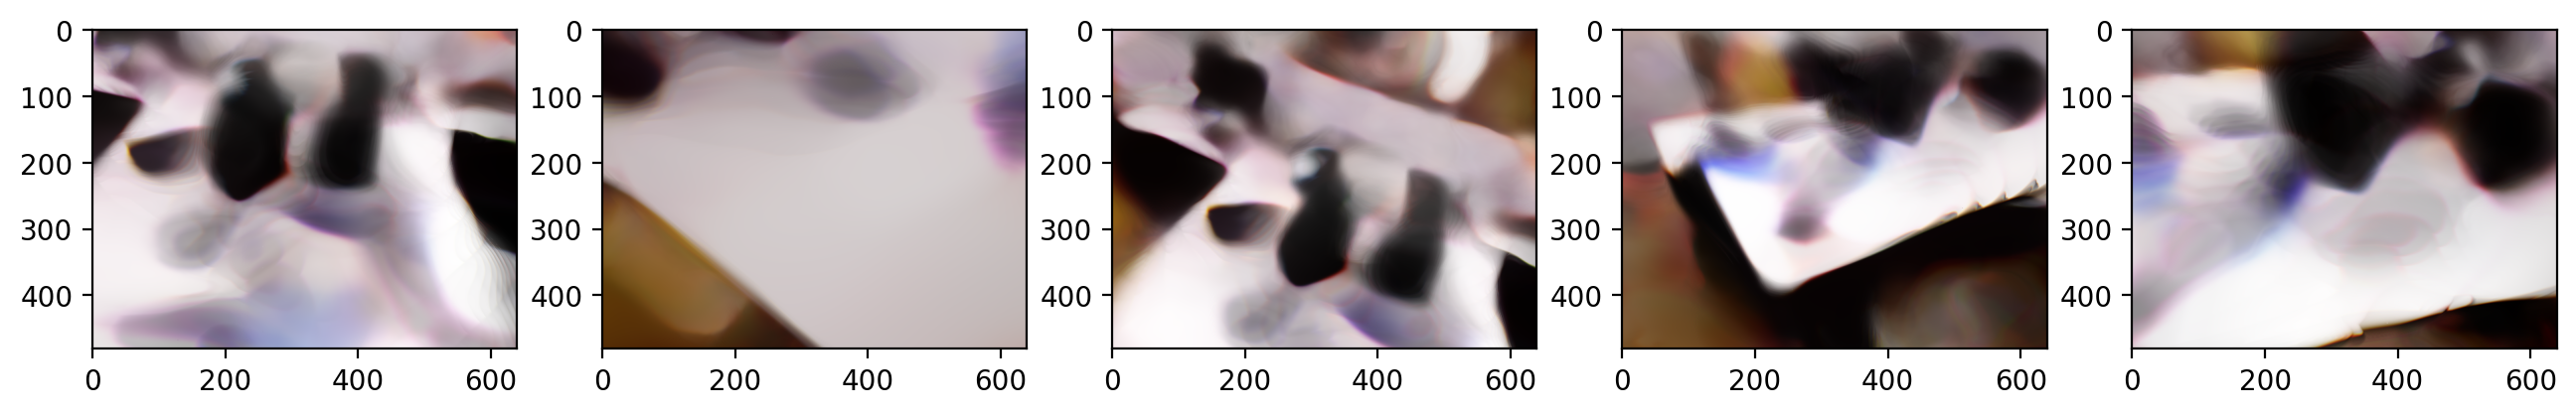

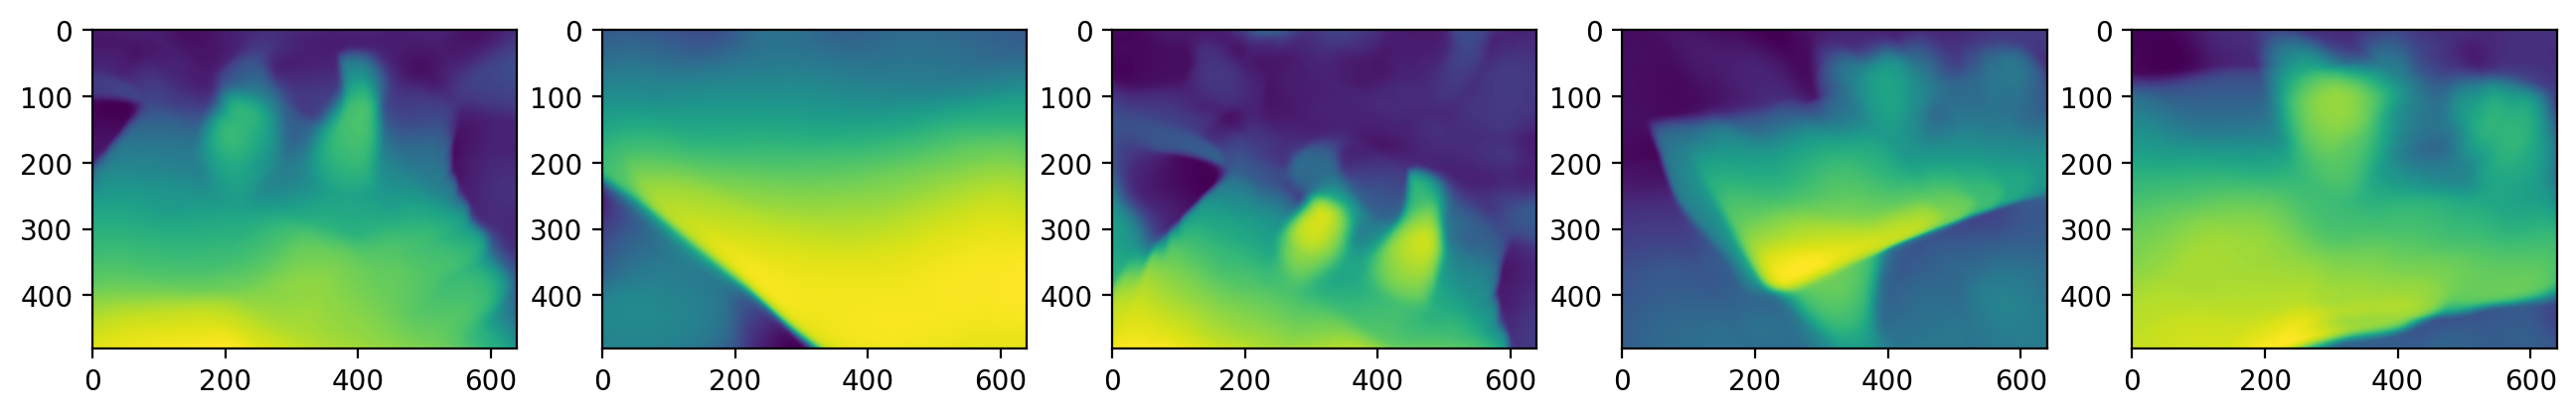

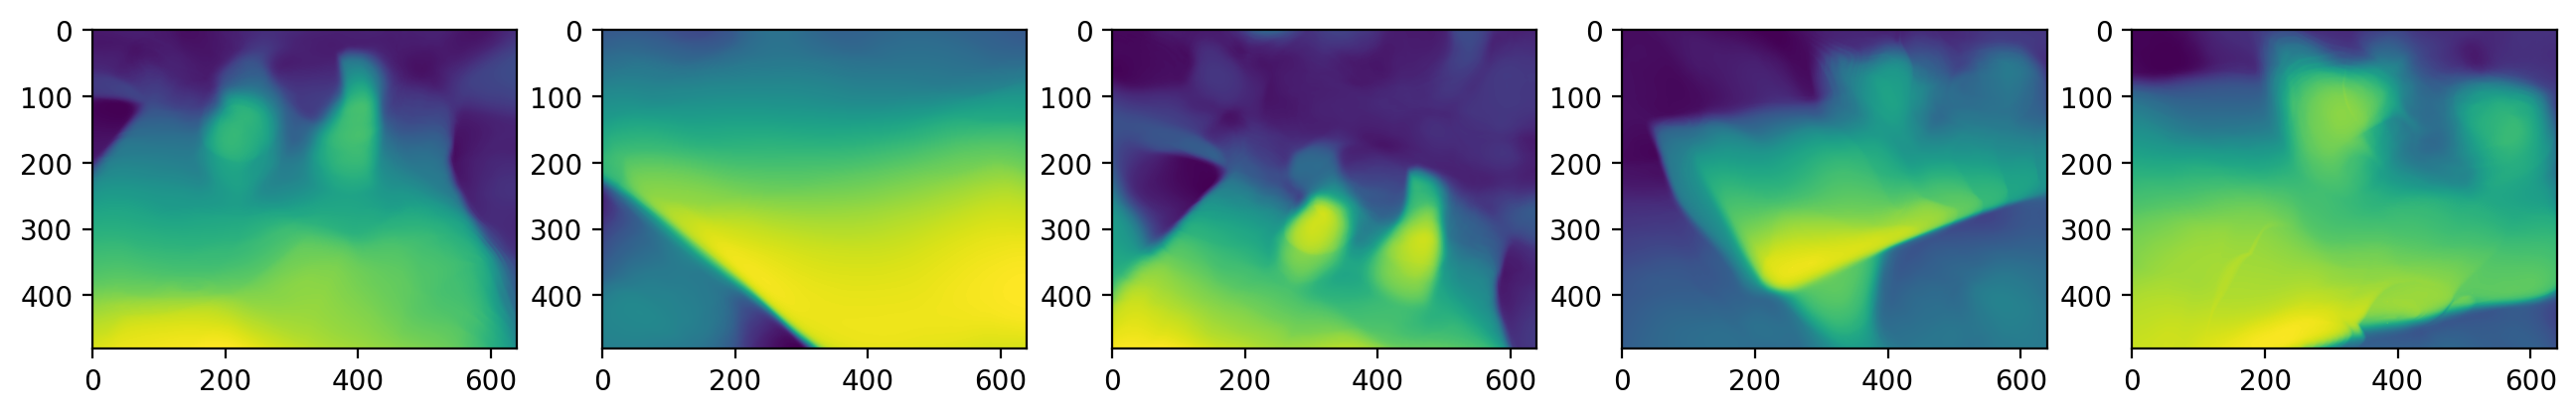

In [14]:
figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.title(f'Frame {i}')
    plt.imshow(cv2.cvtColor(color_coarse_images[i], cv2.COLOR_RGB2BGR))

figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(cv2.cvtColor(color_fine_images[i], cv2.COLOR_RGB2BGR))

figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(1. /depth_coarse_images[i])


figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(len(positions)):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(1. /depth_fine_images[i])

# Position optimization

## Optimization in Ground True position

In [20]:
import pytorch3d

In [27]:
random_pos = torch.from_numpy(positions[0].copy())
random_pos = random_pos.numpy()
print("GT position: \n", positions[0])
print("Optimizaed position: \n", random_pos)
print("=====")
# create state for optimization
for color_image, depth_image, _ in dataset_loader:
        
        color_image = camera.process_color_image(color_image)
        depth_image = camera.process_depth_image(depth_image)[0]
        # processed_random_pose = camera.process_positions(random_pos)
        
        frame = Frame(color_image, depth_image)
        state = State(frame, random_pos)
        state._position.cuda()
        state.train_position()
        model_buffer_input.update_data(state)
        break
print("Optimized position in State")
print("* Parametrized form")
print(state._position)
print("* Matrix form")
print(state.get_matrix_position())

GT position: 
 [[ 0.99142617  0.03231489  0.12660904  0.        ]
 [ 0.11844859 -0.6313777  -0.766376    0.        ]
 [ 0.05517276  0.7748019  -0.62979203  0.        ]
 [ 0.02306    -0.03236     0.16913001  1.        ]]
Optimizaed position: 
 [[ 0.99142617  0.03231489  0.12660904  0.        ]
 [ 0.11844859 -0.6313777  -0.766376    0.        ]
 [ 0.05517276  0.7748019  -0.62979203  0.        ]
 [ 0.02306    -0.03236     0.16913001  1.        ]]
=====
Optimized position in State
* Parametrized form
tensor([ 0.0376, -0.2057,  0.0534, -2.2527, -0.1044, -0.1259],
       requires_grad=True)
* Matrix form
tensor([[ 0.9914,  0.0323,  0.1266,  0.0000],
        [ 0.1184, -0.6314, -0.7664,  0.0000],
        [ 0.0552,  0.7748, -0.6298,  0.0000],
        [ 0.0231, -0.0324,  0.1691,  1.0000]], grad_fn=<SelectBackward>)


In [28]:
# check loss in ground true position
model.eval()
for data_batch in model_buffer_input:
    output = model(data_batch["pixel"].cuda(), data_batch['camera_position'].cuda())
    loss = model.loss(output, data_batch['color'].cuda(), data_batch['depth'].cuda())
for k in loss.keys():
    print(f"{k}", loss[k].item())
del output, loss    
torch.cuda.empty_cache()

course_image_loss 0.11663069576025009
course_depth_loss 0.13698828220367432
fine_image_loss 0.11623265594244003
fine_depth_loss 0.1433424949645996
loss 0.7245057821273804


In [29]:
# model._depth_loss_koef=5.0
model.cuda()
model.train()
state.train_position()
state._position.cuda()
trainer = ModelTrainer([state._position], lr=0.001)
num_epochs = 300
points_per_image = int(640 * 480 / 100)


model_buffer_input = ModelBufferInput(points_per_frame=points_per_image)

model.requires_grad_(False)


for i in tqdm(range(num_epochs)):
    # update model input buffer
    model_buffer_input.update_data(state)
    # train the model
    for batch in model_buffer_input:
        loss = trainer.train(model, batch)
    # trainer.reset_params()
    
    # if i%5 == 0:
    print(f"loss {loss}")
    # clear_output(wait=True)
del loss    
torch.cuda.empty_cache()

  0%|          | 0/300 [00:00<?, ?it/s]

loss 0.7392773628234863
loss 0.7303003668785095
loss 0.718563437461853
loss 0.7101809978485107
loss 0.7444748878479004
loss 0.7341588735580444
loss 0.7336270213127136
loss 0.7329716682434082
loss 0.7160326242446899
loss 0.7289338111877441
loss 0.7193741202354431
loss 0.7277255058288574
loss 0.7287880182266235
loss 0.734824538230896
loss 0.7075797319412231
loss 0.7289213538169861
loss 0.7187029719352722
loss 0.7154309153556824
loss 0.7250146269798279
loss 0.7301017642021179
loss 0.7042609453201294
loss 0.7359533309936523
loss 0.7509235143661499
loss 0.726715087890625
loss 0.724113941192627
loss 0.6940369009971619
loss 0.7461204528808594
loss 0.7305504083633423
loss 0.7333202362060547
loss 0.7237843871116638
loss 0.7253512740135193
loss 0.7303160429000854
loss 0.7043139338493347
loss 0.7328764200210571
loss 0.7261089086532593
loss 0.7206711769104004
loss 0.7204326391220093
loss 0.7211540937423706
loss 0.7266680598258972
loss 0.7206146121025085
loss 0.7208743095397949
loss 0.7256671786308

In [36]:
print("GT position: \n", positions[0])
print("=====")
print("Optimized position in State")
print("* Parametrized form")
print(state._position)
print("* Matrix form")
print(state.get_matrix_position())

GT position: 
 [[ 0.99142617  0.03231489  0.12660904  0.        ]
 [ 0.11844859 -0.6313777  -0.766376    0.        ]
 [ 0.05517276  0.7748019  -0.62979203  0.        ]
 [ 0.02306    -0.03236     0.16913001  1.        ]]
=====
Optimized position in State
* Parametrized form
tensor([ 0.0370, -0.2049,  0.0532, -2.2525, -0.1023, -0.1337],
       requires_grad=True)
* Matrix form
tensor([[ 0.9909,  0.0281,  0.1315,  0.0000],
        [ 0.1195, -0.6317, -0.7660,  0.0000],
        [ 0.0615,  0.7747, -0.6293,  0.0000],
        [ 0.0223, -0.0323,  0.1685,  1.0000]], grad_fn=<SelectBackward>)


In [63]:
random_pos = torch.from_numpy(positions[0].copy())
random_pos = random_pos.numpy()
random_pos[3, :3] += 0.02
print("GT position: \n", positions[0])
print("Optimizaed position: \n", random_pos)
print("=====")
# create state for optimization
for color_image, depth_image, _ in dataset_loader:
        
        color_image = camera.process_color_image(color_image)
        depth_image = camera.process_depth_image(depth_image)[0]
        # processed_random_pose = camera.process_positions(random_pos)
        
        frame = Frame(color_image, depth_image)
        state = State(frame, random_pos)
        state._position.cuda()
        state.train_position()
        model_buffer_input.update_data(state)
        break
print("Optimized position in State")
print("* Parametrized form")
print(state._position)
print("* Matrix form")
print(state.get_matrix_position())

GT position: 
 [[ 0.99142617  0.03231489  0.12660904  0.        ]
 [ 0.11844859 -0.6313777  -0.766376    0.        ]
 [ 0.05517276  0.7748019  -0.62979203  0.        ]
 [ 0.02306    -0.03236     0.16913001  1.        ]]
Optimizaed position: 
 [[ 0.99142617  0.03231489  0.12660904  0.        ]
 [ 0.11844859 -0.6313777  -0.766376    0.        ]
 [ 0.05517276  0.7748019  -0.62979203  0.        ]
 [ 0.04306    -0.01236     0.18913001  1.        ]]
=====
Optimized position in State
* Parametrized form
tensor([ 0.0582, -0.2158,  0.0861, -2.2527, -0.1044, -0.1259],
       requires_grad=True)
* Matrix form
tensor([[ 0.9914,  0.0323,  0.1266,  0.0000],
        [ 0.1184, -0.6314, -0.7664,  0.0000],
        [ 0.0552,  0.7748, -0.6298,  0.0000],
        [ 0.0431, -0.0124,  0.1891,  1.0000]], grad_fn=<SelectBackward>)


In [67]:
# model._depth_loss_koef=5.0
model.cuda()
model.train()
state.train_position()
state._position.cuda()
trainer = ModelTrainer([state._position], lr=0.001)
num_epochs = 300
points_per_image = int(640 * 480 / 100)


model_buffer_input = ModelBufferInput(points_per_frame=points_per_image)

model.requires_grad_(False)


for i in tqdm(range(num_epochs)):
    # update model input buffer
    model_buffer_input.update_data(state)
    # train the model
    for batch in model_buffer_input:
        loss = trainer.train(model, batch)
    # trainer.reset_params()
    
    # if i%5 == 0:
    print(f"loss {loss}")
    # clear_output(wait=True)
del loss    
torch.cuda.empty_cache()

  0%|          | 0/300 [00:00<?, ?it/s]

loss 2.7409286499023438
loss 2.6994385719299316
loss 2.559551239013672
loss 2.4320778846740723
loss 2.371540069580078
loss 2.2957141399383545
loss 2.1917788982391357
loss 2.1437268257141113
loss 2.1056809425354004
loss 2.0002999305725098
loss 1.8713878393173218
loss 1.814414381980896
loss 1.6787928342819214
loss 1.588477611541748
loss 1.51186203956604
loss 1.3270671367645264
loss 1.2249975204467773
loss 1.1951513290405273
loss 1.1342767477035522
loss 1.1174771785736084
loss 1.129111647605896
loss 1.1191593408584595
loss 1.1741178035736084
loss 1.2326363325119019
loss 1.2542928457260132
loss 1.2103183269500732
loss 1.2501301765441895
loss 1.122927188873291
loss 1.138580083847046
loss 1.0799185037612915
loss 1.0491828918457031
loss 1.001427412033081
loss 0.9779927134513855
loss 0.9624274969100952
loss 0.9255965948104858
loss 0.9192171096801758
loss 0.8807701468467712
loss 0.9174407720565796
loss 0.9001604914665222
loss 0.8969768285751343
loss 0.853751540184021
loss 0.8506643176078796
los

In [68]:
print("GT position: \n", positions[0])
print("=====")
print("Optimized position in State")
print("* Parametrized form")
print(state._position)
print("* Matrix form")
print(state.get_matrix_position())

GT position: 
 [[ 0.99142617  0.03231489  0.12660904  0.        ]
 [ 0.11844859 -0.6313777  -0.766376    0.        ]
 [ 0.05517276  0.7748019  -0.62979203  0.        ]
 [ 0.02306    -0.03236     0.16913001  1.        ]]
=====
Optimized position in State
* Parametrized form
tensor([ 0.0367, -0.2045,  0.0532, -2.2519, -0.1020, -0.1339],
       requires_grad=True)
* Matrix form
tensor([[ 0.9909,  0.0278,  0.1315,  0.0000],
        [ 0.1194, -0.6312, -0.7664,  0.0000],
        [ 0.0617,  0.7751, -0.6288,  0.0000],
        [ 0.0221, -0.0323,  0.1682,  1.0000]], grad_fn=<SelectBackward>)


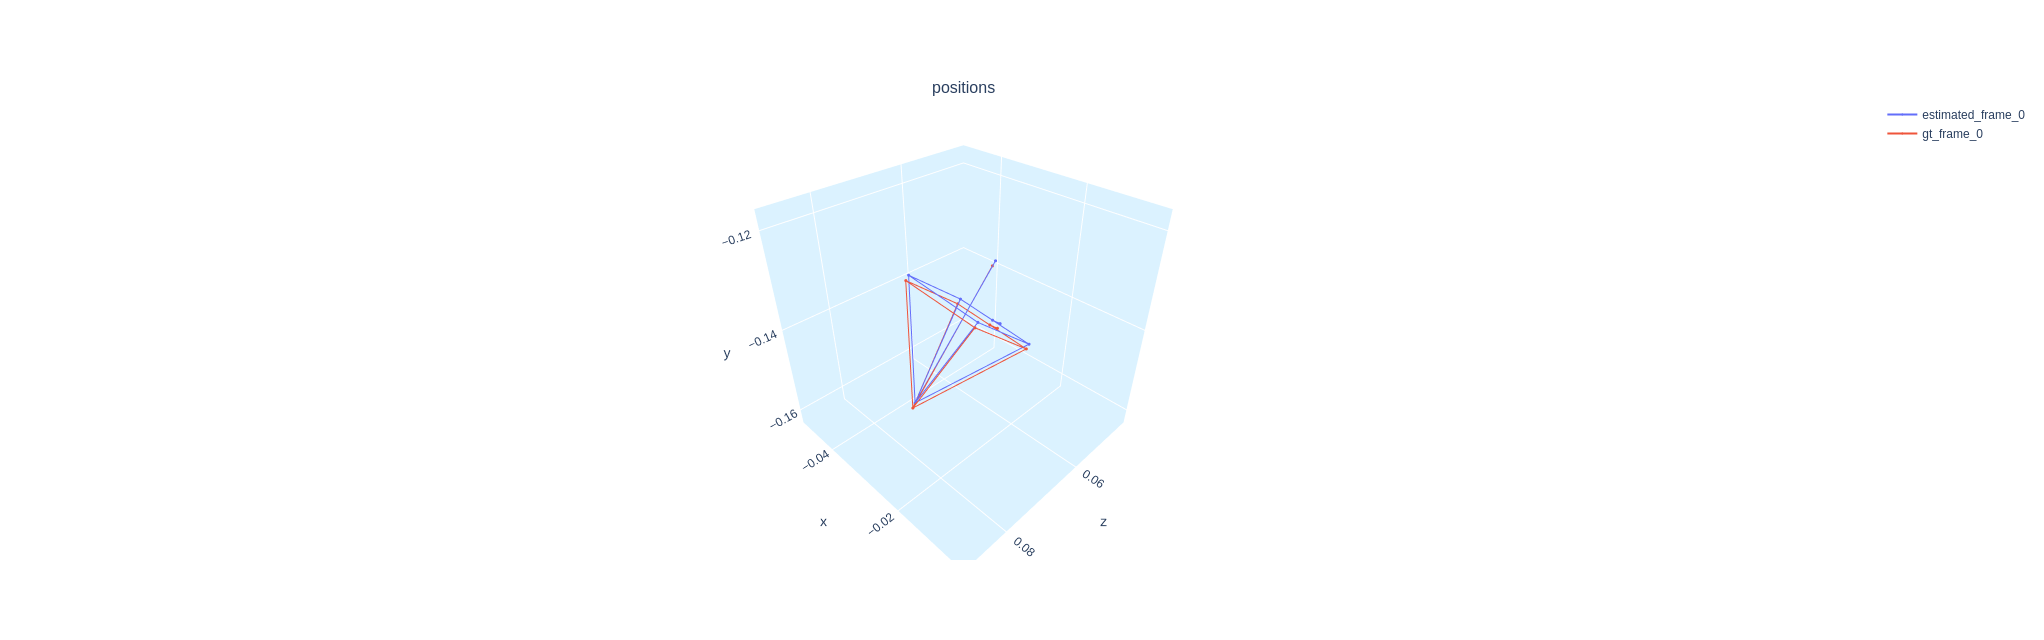

In [69]:
from pytorch3d.renderer.cameras import OrthographicCameras
from pytorch3d.vis.plotly_vis import plot_scene, AxisArgs

np_positions = np.array(positions)
rendered_cameras = {"positions": {}}
rendered_cameras['positions']['estimated_frame_0'] = OrthographicCameras(
    R=state.get_matrix_position()[:3,:3].T[None],
    T=state.get_matrix_position()[3, :3][None]
)
for i in range(len(np_positions)):
    rendered_cameras['positions'][f'gt_frame_{i}'] = OrthographicCameras(
        R=np_positions[i, :3,:3].T[None],
        T=np_positions[i, 3, :3][None])
    break
    
fig = plot_scene(
    rendered_cameras,
    camera_scale=0.01,
    axis_args=AxisArgs(backgroundcolor="#dbf2ff", showgrid=True, showticklabels=True,showaxeslabels=True)
)
fig.update_layout(
    width=960,
    height=640
)
fig.show()

In [65]:
# reder the image

batch_size = 4096

model = model.cuda()
model.eval()


pixels = torch.from_numpy(np_pixels).cuda()

color_coarse_images = []
depth_coarse_images =[]
color_fine_images = []
depth_fine_images = []

mean = camera._color_mean
std = camera._color_std

with torch.no_grad():
    position = state.get_matrix_position().to('cuda')
    output_coarse_color = []
    output_coarse_depth = []
    output_fine_color = []
    output_fine_depth = []

    for i in tqdm(range(pixels.shape[0] // batch_size)):
        output = model(pixels[i * batch_size:i * batch_size + batch_size],
                             position)
        output_coarse_color.append(output[0])
        output_coarse_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

    reconstructed_image = reshape_points_list_to_image(output_coarse_color,height, width, scale).detach().cpu().numpy()
    reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
    reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
    color_coarse_images.append(reconstructed_image)

    reconstructed_image = reshape_points_list_to_image(output_fine_color,height, width, scale).detach().cpu().numpy()
    reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
    reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
    color_fine_images.append(reconstructed_image)

    reconstructed_depth = torch.cat(output_coarse_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
    depth_coarse_images.append(reconstructed_depth)


    reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
    depth_fine_images.append(reconstructed_depth)

del output_coarse_color, output_coarse_depth, output_fine_color, output_fine_depth, position, pixels
torch.cuda.empty_cache()

  0%|          | 0/75 [00:00<?, ?it/s]

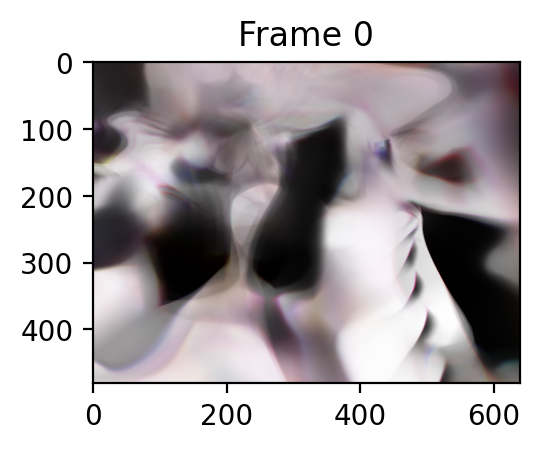

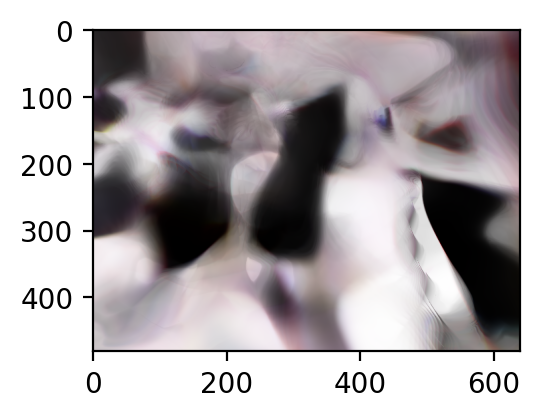

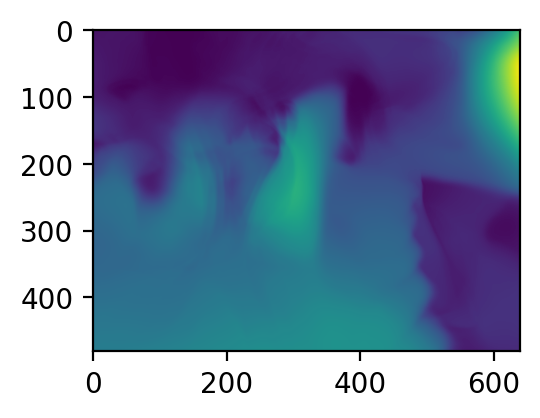

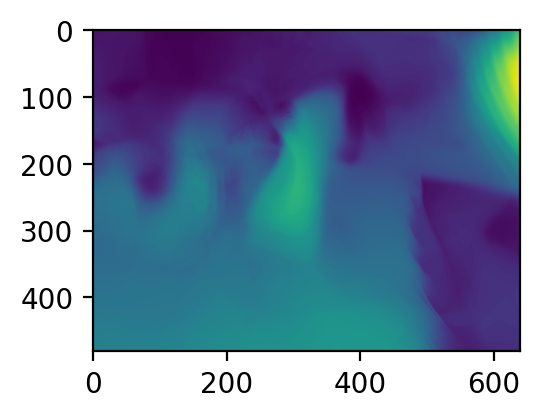

In [66]:
figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(1):
    plt.subplot(1,len(positions),i+1)
    plt.title(f'Frame {i}')
    plt.imshow(cv2.cvtColor(color_coarse_images[i], cv2.COLOR_RGB2BGR))

figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(1):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(cv2.cvtColor(color_fine_images[i], cv2.COLOR_RGB2BGR))

figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(1):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(1. /depth_coarse_images[i])


figure = plt.figure(dpi=200, figsize=(16,10))
for i in range(1):
    plt.subplot(1,len(positions),i+1)
    plt.imshow(1. /depth_fine_images[i])

In [31]:
from pytorch3d.renderer.cameras import OrthographicCameras
from pytorch3d.vis.plotly_vis import plot_scene, AxisArgs

In [32]:
state.get_matrix_position()

tensor([[ 0.9909,  0.0281,  0.1315,  0.0000],
        [ 0.1195, -0.6317, -0.7660,  0.0000],
        [ 0.0615,  0.7747, -0.6293,  0.0000],
        [ 0.0223, -0.0323,  0.1685,  1.0000]], grad_fn=<SelectBackward>)

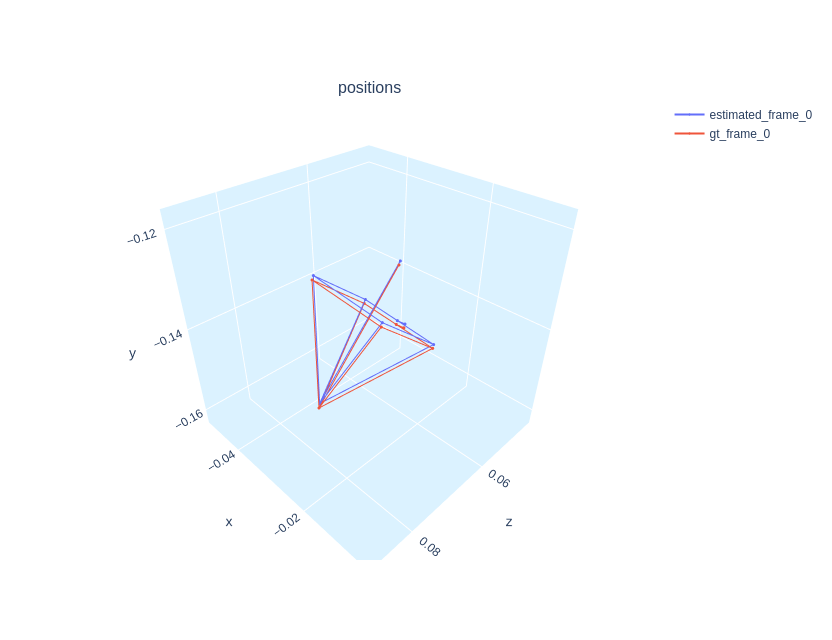

In [33]:
np_positions = np.array(positions)
rendered_cameras = {"positions": {}}
rendered_cameras['positions']['estimated_frame_0'] = OrthographicCameras(
    R=state.get_matrix_position()[:3,:3].T[None],
    T=state.get_matrix_position()[3, :3][None]
)
for i in range(len(np_positions)):
    rendered_cameras['positions'][f'gt_frame_{i}'] = OrthographicCameras(
        R=np_positions[i, :3,:3].T[None],
        T=np_positions[i, 3, :3][None])
    break
    
fig = plot_scene(
    rendered_cameras,
    camera_scale=0.01,
    axis_args=AxisArgs(backgroundcolor="#dbf2ff", showgrid=True, showticklabels=True,showaxeslabels=True)
)
fig.update_layout(
    width=960,
    height=640
)
fig.show()

In [ ]:
model.train()
model.requires_grad_(False)

num_epochs = 300
points_per_image = int(640 * 480 / 100)


model_buffer_input = ModelBufferInput(points_per_frame=points_per_image)

for i in tqdm(range(num_epochs)):
    # update model input buffer
    for position in positions:
        
        color_image = camera.process_color_image(color_image)
        depth_image = camera.process_depth_image(depth_image)[0]
        position = camera.process_positions(position)
        
        frame = Frame(color_image, depth_image)
        state = State(frame, position)
        model_buffer_input.update_data(state)
    # train the model
    for batch in model_buffer_input:
        loss = trainer.train(model, batch)
    # trainer.reset_params()
    
    if i%5 == 0:
        print(f"loss {loss}")
    # clear_output(wait=True)
    
torch.cuda.empty_cache()

In [123]:
from pytorch3d.renderer.cameras import OrthographicCameras
from pytorch3d.vis.plotly_vis import plot_scene, plot_batch_individually, AxisArgs

In [171]:
positions = np.array(positions)
rendered_cameras = {"cameras_positions": {}}
for i in range(len(positions)):
    rendered_cameras['cameras_positions'][f'frame_{i}'] = OrthographicCameras(
        R=positions[i, :3,:3].T[None],
        T=positions[i, 3, :3][None])
                           

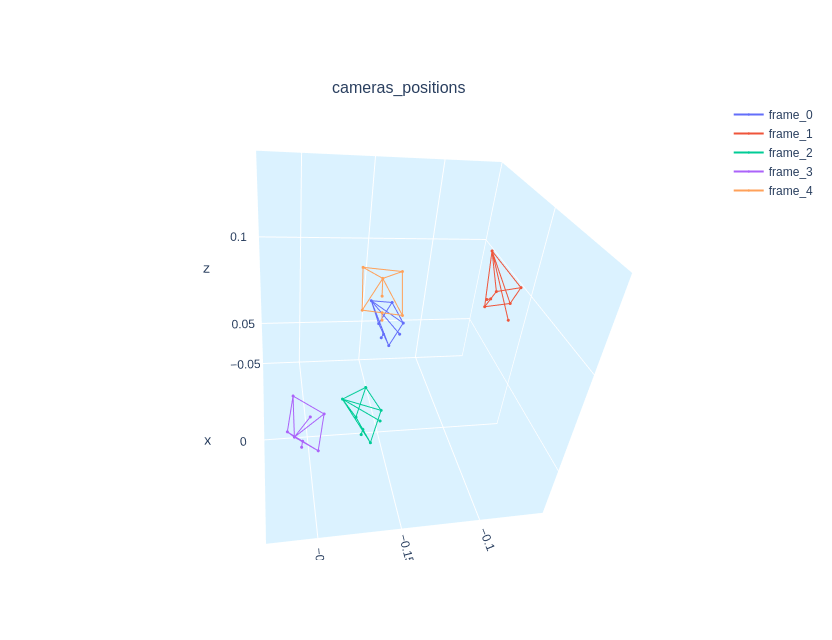

In [173]:
fig = plot_scene(
    rendered_cameras,
    camera_scale=0.01,
    axis_args=AxisArgs(backgroundcolor="#dbf2ff", showgrid=True, showticklabels=True,showaxeslabels=True)
)
fig.update_layout(
    width=960,
    height=640
)
fig.show()